<a href="https://colab.research.google.com/github/DRA-chaos/Quantum-Convolutional-Neural-Network/blob/main/Using_validation_loss_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

     |████████████████████████████████| 6.0MB 10.9MB/s 
     |████████████████████████████████| 18.0MB 178kB/s 
     |████████████████████████████████| 235kB 40.9MB/s 
     |████████████████████████████████| 215kB 37.1MB/s 
     |████████████████████████████████| 2.1MB 31.9MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 1.5MB 30.7MB/s 
     |████████████████████████████████| 194kB 39.3MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 614kB 33.1MB/s 
     |████████████████████████████████| 3.2MB 31.0MB/s 
     |████████████████████████████████| 6.3MB 30.3MB/s 
  Created wheel for qiskit: filename=qiskit-0.27.0-cp37-none-any.whl size=10505 sha256=b78df8f94886a5e80f8ce630f88302713a3148c046011c234de5d339b0538cc3
  Stored in directory: /root/.cache/pip/wheels/c6/54/d9/f0f711dc20aff31947456951374132d0e23ec527da8c15295d
  Created wheel for python-constraint: filename=python_constraint-1.4.0-p

In [2]:
# check if CUDA is available
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [4]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [6]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [7]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [8]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)


Extracting ./data1/cifar-10-python.tar.gz to ./data1


In [9]:
len(cifar_trainset)

50000

In [10]:
from torch.utils.data import DataLoader, random_split

In [11]:
#cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)


labels = cifar_trainset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx] 
cifar_trainset.data = cifar_trainset.data[idx]

cifar_trainset, valid = random_split(cifar_trainset,[150,50])

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=True)

In [12]:
@torch.no_grad()
def get_all_preds(model, train_loader):
    all_preds = torch.tensor([])
    for batch in train_loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

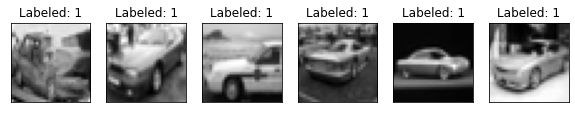

In [13]:
import numpy as np  
import matplotlib.pyplot as plt

n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
  
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [14]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels = cifar_testset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_testset.targets = labels[idx] 
cifar_testset.data = cifar_testset.data[idx]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)

Files already downloaded and verified


In [15]:
len(cifar_testset)

200

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

Epoch: 0 	Training Loss: -0.626067 	Validation Loss: -0.637600
Epoch: 1 	Training Loss: -0.626067 	Validation Loss: -0.733400
Epoch: 2 	Training Loss: -0.626067 	Validation Loss: -0.742800
Epoch: 3 	Training Loss: -0.626067 	Validation Loss: -0.802200
Epoch: 4 	Training Loss: -0.626067 	Validation Loss: -0.835800
Validation loss decreased (inf --> -0.740000).  Saving model ...


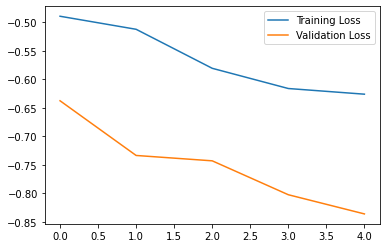

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

In [23]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [24]:
total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )


Performance on train data:
	Loss: -0.7084
	Accuracy: 75.0%


Epoch: 0 	Training Loss: -0.707400 	Validation Loss: -0.730200
Epoch: 1 	Training Loss: -0.707400 	Validation Loss: -0.806400
Epoch: 2 	Training Loss: -0.707400 	Validation Loss: -0.814400
Validation loss decreased (inf --> -0.920000).  Saving model ...


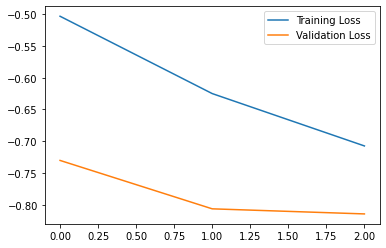

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 3
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

In [26]:
total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on train data:
	Loss: -0.6828
	Accuracy: 68.0%


# With an LR of 0.0008 and epochs =15

Epoch: 0 	Training Loss: -0.788600 	Validation Loss: -0.750600
Epoch: 1 	Training Loss: -0.788600 	Validation Loss: -0.816400
Epoch: 2 	Training Loss: -0.788600 	Validation Loss: -0.865800
Epoch: 3 	Training Loss: -0.788600 	Validation Loss: -0.900200
Epoch: 4 	Training Loss: -0.788600 	Validation Loss: -0.923800
Epoch: 5 	Training Loss: -0.788600 	Validation Loss: -0.931600
Epoch: 6 	Training Loss: -0.788600 	Validation Loss: -0.943400
Epoch: 7 	Training Loss: -0.788600 	Validation Loss: -0.962000
Epoch: 8 	Training Loss: -0.788600 	Validation Loss: -0.974000
Epoch: 9 	Training Loss: -0.788600 	Validation Loss: -0.985000
Epoch: 10 	Training Loss: -0.788600 	Validation Loss: -0.987600
Epoch: 11 	Training Loss: -0.788600 	Validation Loss: -0.988000
Epoch: 12 	Training Loss: -0.788600 	Validation Loss: -0.994200
Epoch: 13 	Training Loss: -0.788600 	Validation Loss: -0.992400
Epoch: 14 	Training Loss: -0.788600 	Validation Loss: -0.994400
Validation loss decreased (inf --> -1.000000).  Sa

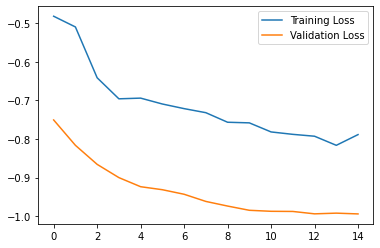

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.0008)
loss_func = nn.NLLLoss()

epochs = 15
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

In [30]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [31]:
total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on train data:
	Loss: -0.7916
	Accuracy: 81.5%


Epoch: 0 	Training Loss: -0.636267 	Validation Loss: -0.446000
Epoch: 1 	Training Loss: -0.636267 	Validation Loss: -0.582200
Epoch: 2 	Training Loss: -0.636267 	Validation Loss: -0.617800
Epoch: 3 	Training Loss: -0.636267 	Validation Loss: -0.645800
Epoch: 4 	Training Loss: -0.636267 	Validation Loss: -0.682000
Epoch: 5 	Training Loss: -0.636267 	Validation Loss: -0.713800
Epoch: 6 	Training Loss: -0.636267 	Validation Loss: -0.761400
Epoch: 7 	Training Loss: -0.636267 	Validation Loss: -0.775600
Epoch: 8 	Training Loss: -0.636267 	Validation Loss: -0.792000
Epoch: 9 	Training Loss: -0.636267 	Validation Loss: -0.808400
Epoch: 10 	Training Loss: -0.636267 	Validation Loss: -0.839200
Epoch: 11 	Training Loss: -0.636267 	Validation Loss: -0.846200
Epoch: 12 	Training Loss: -0.636267 	Validation Loss: -0.845000
Epoch: 13 	Training Loss: -0.636267 	Validation Loss: -0.883000
Epoch: 14 	Training Loss: -0.636267 	Validation Loss: -0.886400
Epoch: 15 	Training Loss: -0.636267 	Validation Lo

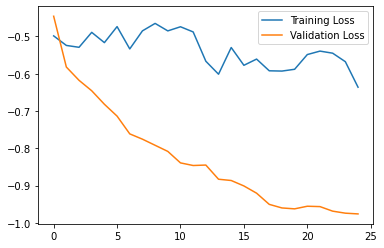

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.0008)
loss_func = nn.NLLLoss()

epochs = 25
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 	Training Loss: -0.558867 	Validation Loss: -0.567200
Epoch: 1 	Training Loss: -0.558867 	Validation Loss: -0.617000
Epoch: 2 	Training Loss: -0.558867 	Validation Loss: -0.581200
Epoch: 3 	Training Loss: -0.558867 	Validation Loss: -0.605000
Epoch: 4 	Training Loss: -0.558867 	Validation Loss: -0.565800


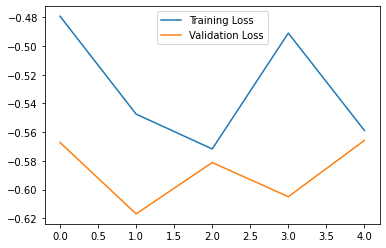

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


In [18]:
total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )


Performance on train data:
	Loss: -0.5689
	Accuracy: 61.5%


Epoch: 0 	Training Loss: -0.681800 	Validation Loss: -0.726800
Epoch: 1 	Training Loss: -0.681800 	Validation Loss: -0.801400
Epoch: 2 	Training Loss: -0.681800 	Validation Loss: -0.808200
Epoch: 3 	Training Loss: -0.681800 	Validation Loss: -0.847200
Epoch: 4 	Training Loss: -0.681800 	Validation Loss: -0.858200


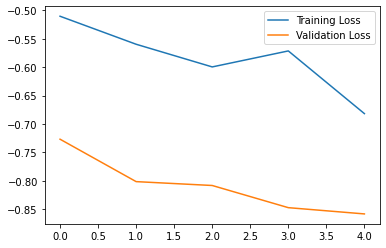

In [19]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


In [20]:
total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on train data:
	Loss: -0.7310
	Accuracy: 76.0%


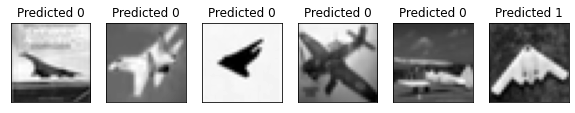

In [21]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        data=data.squeeze()
        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

Epoch: 0 	Training Loss: -0.790267 	Validation Loss: -0.800400
Epoch: 1 	Training Loss: -0.790267 	Validation Loss: -0.777800
Epoch: 2 	Training Loss: -0.790267 	Validation Loss: -0.855400
Epoch: 3 	Training Loss: -0.790267 	Validation Loss: -0.825400
Epoch: 4 	Training Loss: -0.790267 	Validation Loss: -0.867000
Epoch: 5 	Training Loss: -0.790267 	Validation Loss: -0.898000
Epoch: 6 	Training Loss: -0.790267 	Validation Loss: -0.877600
Epoch: 7 	Training Loss: -0.790267 	Validation Loss: -0.915400
Epoch: 8 	Training Loss: -0.790267 	Validation Loss: -0.918600
Epoch: 9 	Training Loss: -0.790267 	Validation Loss: -0.926800


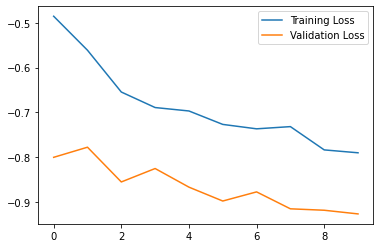

Performance on train data:
	Loss: -0.7769
	Accuracy: 82.0%


In [22]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 10
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.720333 	Validation Loss: -0.747000
Epoch: 1 	Training Loss: -0.720333 	Validation Loss: -0.801000
Epoch: 2 	Training Loss: -0.720333 	Validation Loss: -0.832000
Epoch: 3 	Training Loss: -0.720333 	Validation Loss: -0.870800
Epoch: 4 	Training Loss: -0.720333 	Validation Loss: -0.863400
Epoch: 5 	Training Loss: -0.720333 	Validation Loss: -0.870000
Epoch: 6 	Training Loss: -0.720333 	Validation Loss: -0.867200


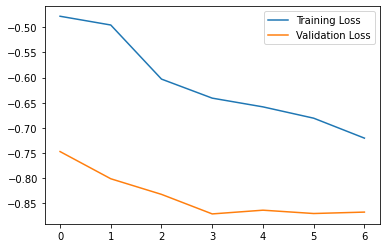

Performance on train data:
	Loss: -0.7197
	Accuracy: 78.0%


In [24]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 7
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.707333 	Validation Loss: -0.744000
Epoch: 1 	Training Loss: -0.707333 	Validation Loss: -0.799600
Epoch: 2 	Training Loss: -0.707333 	Validation Loss: -0.819400
Epoch: 3 	Training Loss: -0.707333 	Validation Loss: -0.843400
Epoch: 4 	Training Loss: -0.707333 	Validation Loss: -0.834400
Epoch: 5 	Training Loss: -0.707333 	Validation Loss: -0.860800
Epoch: 6 	Training Loss: -0.707333 	Validation Loss: -0.881800
Epoch: 7 	Training Loss: -0.707333 	Validation Loss: -0.880400


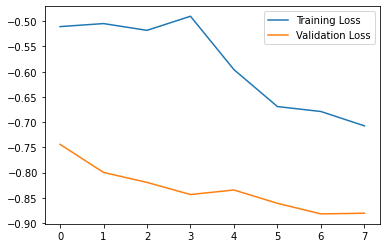

Performance on train data:
	Loss: -0.7404
	Accuracy: 77.0%


In [27]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 8
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.734200 	Validation Loss: -0.788800
Epoch: 1 	Training Loss: -0.734200 	Validation Loss: -0.842000
Epoch: 2 	Training Loss: -0.734200 	Validation Loss: -0.866000
Epoch: 3 	Training Loss: -0.734200 	Validation Loss: -0.887200
Epoch: 4 	Training Loss: -0.734200 	Validation Loss: -0.890000
Epoch: 5 	Training Loss: -0.734200 	Validation Loss: -0.885600
Epoch: 6 	Training Loss: -0.734200 	Validation Loss: -0.897800
Epoch: 7 	Training Loss: -0.734200 	Validation Loss: -0.914800
Epoch: 8 	Training Loss: -0.734200 	Validation Loss: -0.933200


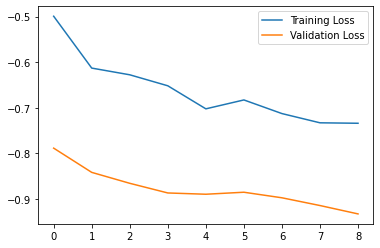

Performance on train data:
	Loss: -0.7684
	Accuracy: 81.0%


In [28]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 9
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.620800 	Validation Loss: -0.754600
Epoch: 1 	Training Loss: -0.620800 	Validation Loss: -0.791600
Epoch: 2 	Training Loss: -0.620800 	Validation Loss: -0.819600
Epoch: 3 	Training Loss: -0.620800 	Validation Loss: -0.822200
Epoch: 4 	Training Loss: -0.620800 	Validation Loss: -0.841800
Epoch: 5 	Training Loss: -0.620800 	Validation Loss: -0.880000


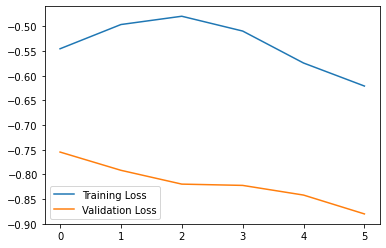

Performance on train data:
	Loss: -0.7780
	Accuracy: 81.5%


In [29]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 6
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.715867 	Validation Loss: -0.783400
Epoch: 1 	Training Loss: -0.715867 	Validation Loss: -0.816200
Epoch: 2 	Training Loss: -0.715867 	Validation Loss: -0.834600
Epoch: 3 	Training Loss: -0.715867 	Validation Loss: -0.865200
Epoch: 4 	Training Loss: -0.715867 	Validation Loss: -0.869800
Epoch: 5 	Training Loss: -0.715867 	Validation Loss: -0.884600


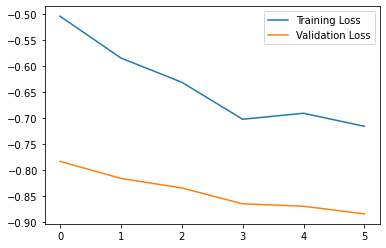

Performance on train data:
	Loss: -0.7421
	Accuracy: 78.0%


In [30]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
loss_func = nn.NLLLoss()

epochs = 6
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.699533 	Validation Loss: -0.777600
Epoch: 1 	Training Loss: -0.699533 	Validation Loss: -0.817400
Epoch: 2 	Training Loss: -0.699533 	Validation Loss: -0.858200
Epoch: 3 	Training Loss: -0.699533 	Validation Loss: -0.866400
Epoch: 4 	Training Loss: -0.699533 	Validation Loss: -0.857600


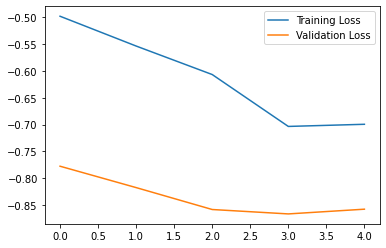

Performance on train data:
	Loss: -0.7549
	Accuracy: 78.0%


In [32]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.532400 	Validation Loss: -0.559000
Epoch: 1 	Training Loss: -0.532400 	Validation Loss: -0.434400
Epoch: 2 	Training Loss: -0.532400 	Validation Loss: -0.493600
Epoch: 3 	Training Loss: -0.532400 	Validation Loss: -0.438400
Epoch: 4 	Training Loss: -0.532400 	Validation Loss: -0.548800
Epoch: 5 	Training Loss: -0.532400 	Validation Loss: -0.477800
Epoch: 6 	Training Loss: -0.532400 	Validation Loss: -0.537800


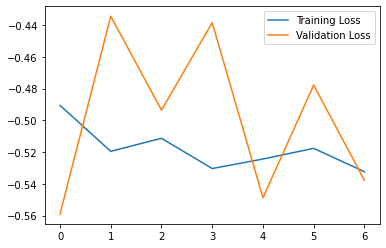

Performance on train data:
	Loss: -0.5010
	Accuracy: 48.5%


In [37]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
loss_func = nn.NLLLoss()

epochs = 7
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.505200 	Validation Loss: -0.507400
Epoch: 1 	Training Loss: -0.505200 	Validation Loss: -0.512400
Epoch: 2 	Training Loss: -0.505200 	Validation Loss: -0.524800
Epoch: 3 	Training Loss: -0.505200 	Validation Loss: -0.541800
Epoch: 4 	Training Loss: -0.505200 	Validation Loss: -0.564000
Epoch: 5 	Training Loss: -0.505200 	Validation Loss: -0.578000
Epoch: 6 	Training Loss: -0.505200 	Validation Loss: -0.589200
Epoch: 7 	Training Loss: -0.505200 	Validation Loss: -0.600800
Epoch: 8 	Training Loss: -0.505200 	Validation Loss: -0.600600
Epoch: 9 	Training Loss: -0.505200 	Validation Loss: -0.599000


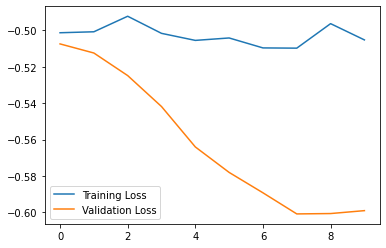

In [41]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

In [42]:
total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on train data:
	Loss: -0.5369
	Accuracy: 50.0%


Epoch: 0 	Training Loss: -0.741600 	Validation Loss: -0.758400
Epoch: 1 	Training Loss: -0.741600 	Validation Loss: -0.812200
Epoch: 2 	Training Loss: -0.741600 	Validation Loss: -0.832000
Epoch: 3 	Training Loss: -0.741600 	Validation Loss: -0.861000
Epoch: 4 	Training Loss: -0.741600 	Validation Loss: -0.899000
Epoch: 5 	Training Loss: -0.741600 	Validation Loss: -0.902600
Epoch: 6 	Training Loss: -0.741600 	Validation Loss: -0.926600
Epoch: 7 	Training Loss: -0.741600 	Validation Loss: -0.925200
Epoch: 8 	Training Loss: -0.741600 	Validation Loss: -0.945000
Epoch: 9 	Training Loss: -0.741600 	Validation Loss: -0.952000
Epoch: 10 	Training Loss: -0.741600 	Validation Loss: -0.957800
Epoch: 11 	Training Loss: -0.741600 	Validation Loss: -0.958200
Epoch: 12 	Training Loss: -0.741600 	Validation Loss: -0.975600
Epoch: 13 	Training Loss: -0.741600 	Validation Loss: -0.980600
Epoch: 14 	Training Loss: -0.741600 	Validation Loss: -0.979400


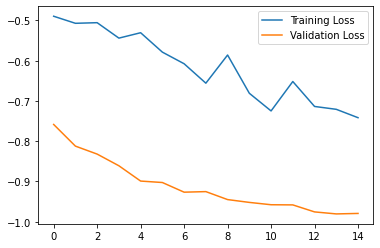

In [43]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 15
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

The above graph shows that the model suffers through overfitting

In [44]:
total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on train data:
	Loss: -0.7533
	Accuracy: 77.0%


Epoch: 0 	Training Loss: -0.470133 	Validation Loss: -0.426800
Epoch: 1 	Training Loss: -0.470133 	Validation Loss: -0.533200
Epoch: 2 	Training Loss: -0.470133 	Validation Loss: -0.528200
Epoch: 3 	Training Loss: -0.470133 	Validation Loss: -0.464600
Epoch: 4 	Training Loss: -0.470133 	Validation Loss: -0.478200
Epoch: 5 	Training Loss: -0.470133 	Validation Loss: -0.418400
Epoch: 6 	Training Loss: -0.470133 	Validation Loss: -0.492200
Epoch: 7 	Training Loss: -0.470133 	Validation Loss: -0.534000
Epoch: 8 	Training Loss: -0.470133 	Validation Loss: -0.472600
Epoch: 9 	Training Loss: -0.470133 	Validation Loss: -0.531400
Epoch: 10 	Training Loss: -0.470133 	Validation Loss: -0.459600
Epoch: 11 	Training Loss: -0.470133 	Validation Loss: -0.513200
Epoch: 12 	Training Loss: -0.470133 	Validation Loss: -0.535200
Epoch: 13 	Training Loss: -0.470133 	Validation Loss: -0.484000
Epoch: 14 	Training Loss: -0.470133 	Validation Loss: -0.521600


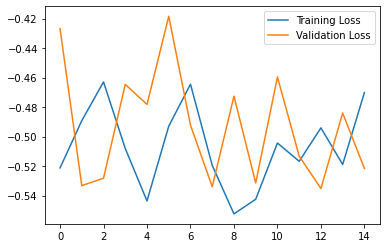

In [45]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.NLLLoss()

epochs = 15
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

In [46]:
total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on train data:
	Loss: -0.5075
	Accuracy: 50.0%


Epoch: 0 	Training Loss: -0.730200 	Validation Loss: -0.746000
Epoch: 1 	Training Loss: -0.730200 	Validation Loss: -0.774200
Epoch: 2 	Training Loss: -0.730200 	Validation Loss: -0.801000
Epoch: 3 	Training Loss: -0.730200 	Validation Loss: -0.804200
Epoch: 4 	Training Loss: -0.730200 	Validation Loss: -0.828200
Epoch: 5 	Training Loss: -0.730200 	Validation Loss: -0.868000
Epoch: 6 	Training Loss: -0.730200 	Validation Loss: -0.894400
Epoch: 7 	Training Loss: -0.730200 	Validation Loss: -0.894800
Epoch: 8 	Training Loss: -0.730200 	Validation Loss: -0.934200
Epoch: 9 	Training Loss: -0.730200 	Validation Loss: -0.947000
Epoch: 10 	Training Loss: -0.730200 	Validation Loss: -0.961400
Epoch: 11 	Training Loss: -0.730200 	Validation Loss: -0.969200
Epoch: 12 	Training Loss: -0.730200 	Validation Loss: -0.977200
Epoch: 13 	Training Loss: -0.730200 	Validation Loss: -0.988000
Epoch: 14 	Training Loss: -0.730200 	Validation Loss: -0.987400


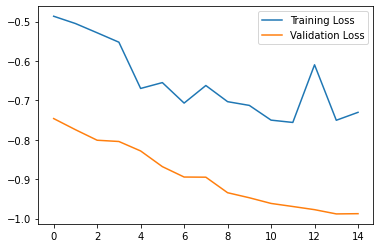

Performance on test data:
	Loss: -0.7544
	Accuracy: 79.0%


In [47]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 15
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.513667 	Validation Loss: -0.438200
Epoch: 1 	Training Loss: -0.513667 	Validation Loss: -0.493600
Epoch: 2 	Training Loss: -0.513667 	Validation Loss: -0.581200
Epoch: 3 	Training Loss: -0.513667 	Validation Loss: -0.679200
Epoch: 4 	Training Loss: -0.513667 	Validation Loss: -0.724400
Epoch: 5 	Training Loss: -0.513667 	Validation Loss: -0.787000
Epoch: 6 	Training Loss: -0.513667 	Validation Loss: -0.794600
Epoch: 7 	Training Loss: -0.513667 	Validation Loss: -0.796000
Epoch: 8 	Training Loss: -0.513667 	Validation Loss: -0.807200
Epoch: 9 	Training Loss: -0.513667 	Validation Loss: -0.857800


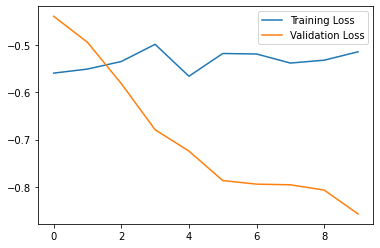

Performance on test data:
	Loss: -0.7366
	Accuracy: 80.5%


In [48]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 10
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.490600 	Validation Loss: -0.417400
Epoch: 1 	Training Loss: -0.490600 	Validation Loss: -0.507200
Epoch: 2 	Training Loss: -0.490600 	Validation Loss: -0.520800


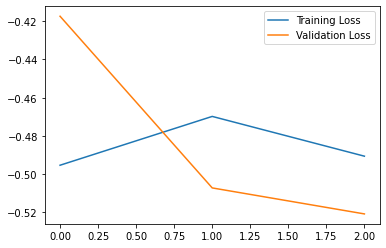

Performance on test data:
	Loss: -0.5172
	Accuracy: 52.5%


In [49]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 3
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.471067 	Validation Loss: -0.378800
Epoch: 1 	Training Loss: -0.471067 	Validation Loss: -0.484600
Epoch: 2 	Training Loss: -0.471067 	Validation Loss: -0.509200
Epoch: 3 	Training Loss: -0.471067 	Validation Loss: -0.493800
Epoch: 4 	Training Loss: -0.471067 	Validation Loss: -0.526600
Epoch: 5 	Training Loss: -0.471067 	Validation Loss: -0.486800
Epoch: 6 	Training Loss: -0.471067 	Validation Loss: -0.533800


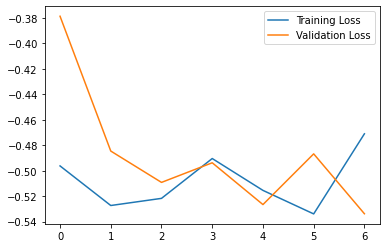

Performance on test data:
	Loss: -0.4957
	Accuracy: 52.0%


In [50]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 7
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.498733 	Validation Loss: -0.619600
Epoch: 1 	Training Loss: -0.498733 	Validation Loss: -0.675800
Epoch: 2 	Training Loss: -0.498733 	Validation Loss: -0.677000
Epoch: 3 	Training Loss: -0.498733 	Validation Loss: -0.657600
Epoch: 4 	Training Loss: -0.498733 	Validation Loss: -0.651200
Epoch: 5 	Training Loss: -0.498733 	Validation Loss: -0.700800
Epoch: 6 	Training Loss: -0.498733 	Validation Loss: -0.673200
Epoch: 7 	Training Loss: -0.498733 	Validation Loss: -0.696000
Epoch: 8 	Training Loss: -0.498733 	Validation Loss: -0.694800
Epoch: 9 	Training Loss: -0.498733 	Validation Loss: -0.719000


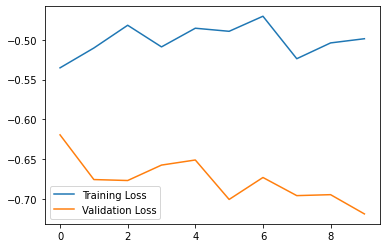

Performance on test data:
	Loss: -0.6472
	Accuracy: 69.5%


In [51]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
loss_func = nn.NLLLoss()

epochs = 10
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.455533 	Validation Loss: -0.556800
Epoch: 1 	Training Loss: -0.455533 	Validation Loss: -0.584400
Epoch: 2 	Training Loss: -0.455533 	Validation Loss: -0.591200
Epoch: 3 	Training Loss: -0.455533 	Validation Loss: -0.587800
Epoch: 4 	Training Loss: -0.455533 	Validation Loss: -0.650800
Epoch: 5 	Training Loss: -0.455533 	Validation Loss: -0.654400
Epoch: 6 	Training Loss: -0.455533 	Validation Loss: -0.699800
Epoch: 7 	Training Loss: -0.455533 	Validation Loss: -0.671200
Epoch: 8 	Training Loss: -0.455533 	Validation Loss: -0.710600
Epoch: 9 	Training Loss: -0.455533 	Validation Loss: -0.768600
Epoch: 10 	Training Loss: -0.455533 	Validation Loss: -0.802400
Epoch: 11 	Training Loss: -0.455533 	Validation Loss: -0.794200
Epoch: 12 	Training Loss: -0.455533 	Validation Loss: -0.832200
Epoch: 13 	Training Loss: -0.455533 	Validation Loss: -0.838000
Epoch: 14 	Training Loss: -0.455533 	Validation Loss: -0.847000


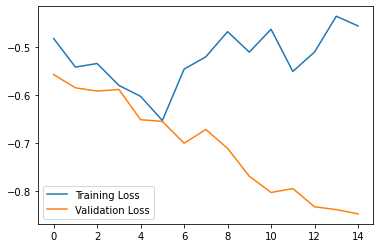

Performance on test data:
	Loss: -0.7039
	Accuracy: 77.0%


In [52]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
loss_func = nn.NLLLoss()

epochs = 15
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.723733 	Validation Loss: -0.637800
Epoch: 1 	Training Loss: -0.723733 	Validation Loss: -0.751000
Epoch: 2 	Training Loss: -0.723733 	Validation Loss: -0.813000
Epoch: 3 	Training Loss: -0.723733 	Validation Loss: -0.835600
Epoch: 4 	Training Loss: -0.723733 	Validation Loss: -0.853600


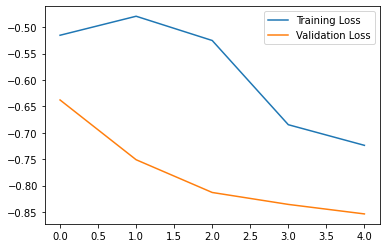

Performance on test data:
	Loss: -0.7523
	Accuracy: 78.0%


In [53]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 0 	Training Loss: -0.498533 	Validation Loss: -0.469600
Epoch: 1 	Training Loss: -0.498533 	Validation Loss: -0.506600
Epoch: 2 	Training Loss: -0.498533 	Validation Loss: -0.562600


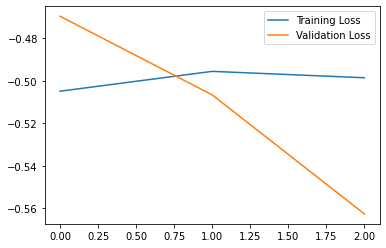

Performance on test data:
	Loss: -0.5128
	Accuracy: 52.5%


In [54]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
loss_func = nn.NLLLoss()

epochs = 3
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, loss_list[-1], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 

total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )